In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

# Tutorial: Custom priors

In this tutorial, we will explore the benefits of using a custom prior in solving the Branched Optimal Transport (BOT) problem. The BOT problem involves finding the optimal transportation plan between a set of source and sink nodes, considering the branching structure of the network. Initially, we will employ two natural starting points: the **Optimal Transport** (OT) solution for alpha close to 1 and the **Minimum Spanning Tree** (MST) solution for alpha close to zero, where flows are less important. We will assess the execution times and performance of both approaches. The OT solution provides an informed prior that considers the optimal transportation plan, while the MST solution offers a more simplistic prior for a MST-like problem with a low value of α.

To answer the question of _why we use custom priors instead of simply relying on star graphs_, it is important to understand the limitations of star graphs as a solution. While star graphs are always a valid solution, they often fail to capture the underlying structure of the problem, resulting in suboptimal performance. Star graphs provide a simplistic representation that considers only direct connections between the central node and the other nodes, disregarding the intricate relationships and dependencies within the network.

### Defining auxiliary function
To get started, we will import the necessary modules and define the main auxiliary function `optimize_topology` that will take care of performing both the geometry and the topology optimization; for more info about this check `tutorial-1-solving-branched-optimal-transport-problems.ipynb`):

In [45]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import time
#-------------------------------------------
#import MST_prior as mst
import interpolating_prior as ip
import utils
import iterative_geometry_solver as igs
import greedy_topology_optimization as gto 

In [46]:
def optimize_topology(topo):
    # Geometry optimization
    cost, coords_iter = igs.iterative_geometry_solver(topo,
                                                      supply_arr, 
                                                      demand_arr, 
                                                      coords_sources, 
                                                      coords_sinks, 
                                                      al,
                                                      relative_improvement_threshold=1e-6,
                                                      min_iterations=-1,
                                                      max_iterations=1000,
                                                      plot=False,
                                                      title="",
                                                      fov=None,
                                                      save=False,
                                                      save_name="img",
                                                      figsize=(4,4))
    
    # Topology optimization
    T = 0
    keep_going = True
    iteration = 0
    sample_edge_list = list(topo.edges())

    time0 = time.time()
    while keep_going and iteration < 60000:
        iteration += 1
        topo, sample_edge_list, cost, coords_iter, accepted = gto.monte_carlo_step(topo, sample_edge_list, cost,
                                                                                   coords_iter, bot_problem_dict,
                                                                                   temperature=T)
        # check if converged
        if len(sample_edge_list) == 0:
            # this means that we have stuck with one topology for an entire run through.
            keep_going = False

    execution_time = np.round(time.time() - time0, 2)
    print(f"Final result, after {iteration} iterations and {execution_time} seconds.")
    
    # Visualization
    
    utils.visualise_BOT_solution(topo, 
                       coords_iter, 
                       supply_arr, 
                       demand_arr, 
                       title="", fov=None, save=False, save_name="img",
                       figsize = (4,4))
    
    return topo, iteration, execution_time, cost

### Defining Problem Parameters
Next, the code defines the problem parameters. The snippet contains the following lines:

In [47]:
seed=138
np.random.seed(seed)
num_terminals = 20

### Generating Random Problem
The code generates a random problem using the `generate_random_bot_problem` function. It sets the number of sources and sinks randomly and retrieves the problem dictionary containing coordinates, supply, and demand arrays.

In [48]:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = utils.generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                       max_length=1.)

We redefine the parameter $\alpha$ to make it be **more similar to the MST regime**.

In [49]:
bot_problem_dict['al'] = 0.1

Let's now extract the information defining the problem into a set of variables.

In [50]:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

Notice that in this case, the number of sources and sinks is:

In [51]:
print(len(coords_sources))
print(len(coords_sinks))

10
10


### Uninformed prior: Star graph
To begin, we will establish an initial topology to work with. In this particular case, we will create a star graph as our starting point.

In [52]:
# init star graph:
star = nx.Graph()
for node in range(len(supply_arr) + len(demand_arr)):
    star.add_edge(-1, node)

Notice that this graph has the following properties:

In [53]:
# The number of nodes
num_nodes = star.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = star.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 21
Number of edges: 20


And it looks like this:

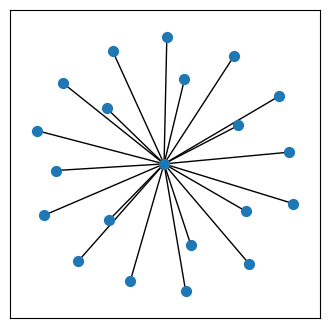

In [54]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(star, seed = 1)
nx.draw_networkx(star, pos = pos, node_size = 50, with_labels = False)

This graph can be considered as our initial approximation of the solution to the problem of connecting the given sources and sinks.

### Solving the problem
We finally solve the problem using our auxiliary function. We stored the execution time, among other things. The next cell also gets us a plot of the solution.

Final result, after 176 iterations and 2.15 seconds.


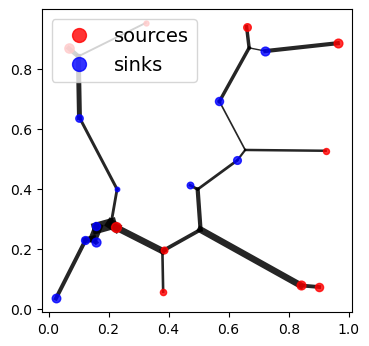

In [55]:
star, iteration_star, execution_star, cost_star = optimize_topology(star)

## Custom prior: Minimum Spanning Tree
We use the module `interpolating_prior` to build the MST using the coordinates of the sources and sinks. The script takes care of designing an interpolating topology given a BOT problem. It interpolates between the OT (beta=0) and the MST (beta=1) topologies.


A **Minimum Spanning Tree (MST)** is a tree that connects all the vertices of a given graph with the minimum possible total edge weight. In an MST, every vertex is included, and there are no cycles or redundant edges. 

In [64]:
# init graph:
beta = 1
mst_graph = ip.interpolated_prior(bot_problem_dict, beta)

Notice that this graph has the following properties:

In [65]:
# The number of nodes
num_nodes = mst_graph.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = mst_graph.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 34
Number of edges: 33


And it looks like this:

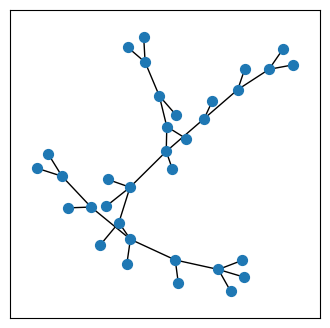

In [66]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(mst_graph, seed = 1)
nx.draw_networkx(mst_graph, pos = pos, node_size = 50, with_labels = False)

### Solving the BOT problem with an informed MST prior

Finally, we solve the problem making use of this topology.

Final result, after 74 iterations and 0.75 seconds.


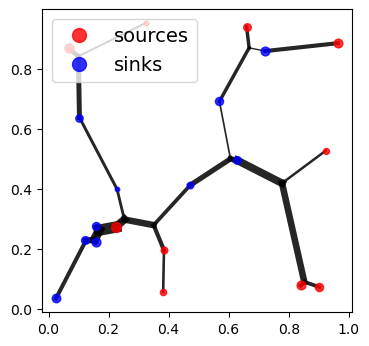

In [67]:
mst_graph, iteration_mst, execution_mst, cost_mst = optimize_topology(mst_graph)

In [68]:
execution_mst

0.75

We can observe that the MST consistently achieves significantly reduced execution time of the algorithm. This improvement in efficiency comes with a very similar cost, indicating that the MST achieves comparable results to the initial case while requiring fewer iterations.

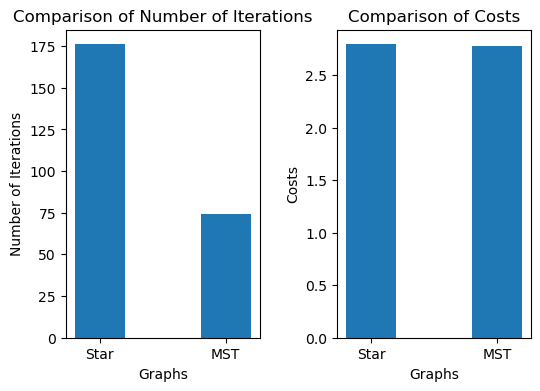

In [69]:
# Create subplots with a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Plot 1: Number of Iterations
num_iterations = [iteration_star, iteration_mst]
axs[0].bar(labels, num_iterations, width=0.4)
axs[0].set_xlabel('Graphs')
axs[0].set_ylabel('Number of Iterations')
axs[0].set_title('Comparison of Number of Iterations')

# Plot 2: Costs
costs = [cost_star, cost_mst]  # Replace with your actual costs
axs[1].bar(labels, costs, width=0.4)
axs[1].set_xlabel('Graphs')
axs[1].set_ylabel('Costs')
axs[1].set_title('Comparison of Costs')

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plots
plt.show()


Congratulations! We have successfully solved a BOT problem with an **informed prior** to get faster and still  accurate results. 